In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing import Annotated, TypedDict, List, Any, Optional
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from langgraph.graph import END, StateGraph
from pydantic import BaseModel, Field
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
import asyncio
import uuid
import os

In [3]:
load_dotenv(override=True)
google_api_key = os.getenv("GOOGLE_API_KEY")
if not google_api_key:
    raise ValueError("GOOGLE_API_KEY not found in .env file")

In [4]:
llm_1 = ChatGoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=google_api_key)
llm_2 = ChatGoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=google_api_key)

In [5]:
class EvaluatorOutput(BaseModel):
    feedback: str = Field(description="Feedback on the assistant's response")
    success_criteria_met: bool = Field(description="Whether the success criteria have been met")
    user_input_needed: bool = Field(description="True if more input is needed from the user, or clarifications, or the assistant is stuck")

In [6]:
class State(TypedDict):
    messages: Annotated[List[Any], add_messages]
    success_criteria: str
    feedback_on_work: Optional[str]
    success_criteria_met: bool
    user_input_needed: bool
    iteration_count: int

In [7]:
worker_llm = llm_1
evaluator_llm = llm_2
evaluator_llm_with_output = evaluator_llm.with_structured_output(EvaluatorOutput)

In [8]:
# Worker node to extract flight details
def worker(state: State) -> dict:
    system_message = f"""You are a helpful travel assistant that extracts flight details from user queries.
    You keep working on extracting details until either you have a question or clarification for the user, or all required details are obtained.
    Required details: departure city, arrival city, departure date.
    Optional: return date, number of passengers, travel class, additional notes.
    This is the success criteria:
    {state['success_criteria']}
    You should reply either with a question for the user, or with your final response listing the details.
    If you have a question, reply by clearly stating 'Question: [your question]'.
    If you've finished, reply with a confirmation message listing all details, e.g., 'Here are the flight details: Departure from [city], Arrival at [city], on [date].'"""
    
    if state.get("feedback_on_work"):
        system_message += f"""
    Previously you thought you completed the task, but it was rejected because the success criteria was not met.
    Here is the feedback:
    {state['feedback_on_work']}
    With this feedback, continue, ensuring you meet the criteria or ask a question."""
    
    found_system_message = False
    messages = state["messages"]
    for message in messages:
        if isinstance(message, SystemMessage):
            message.content = system_message
            found_system_message = True
    
    if not found_system_message:
        messages = [SystemMessage(content=system_message)] + messages
    
    response = worker_llm.invoke(messages)
    
    return {
        "messages": [response],
    }

In [9]:
def format_conversation(messages: List[Any]) -> str:
    conversation = "Conversation history:\n\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text = message.content or "[No content]"
            conversation += f"Assistant: {text}\n"
    return conversation

In [10]:
def evaluator(state: State) -> dict:
    last_response = state["messages"][-1].content

    system_message = """You are an evaluator that determines if a task has been completed successfully by an Assistant.
    Assess the Assistant's last response based on the given criteria. Respond with your feedback, and with your decision on whether the success criteria has been met,
    and whether more input is needed from the user."""
    
    user_message = f"""You are evaluating a conversation between the User and Assistant. You decide what action to take based on the last response from the Assistant.

    The entire conversation with the assistant, with the user's original request and all replies, is:
    {format_conversation(state['messages'])}

    The success criteria for this assignment is:
    {state['success_criteria']}

    And the final response from the Assistant that you are evaluating is:
    {last_response}

    Respond with your feedback, and decide if the success criteria is met by this response.
    Also, decide if more user input is required, either because the assistant has a question, needs clarification, or seems to be stuck and unable to answer without help.
    """
    if state["feedback_on_work"]:
        user_message += f"Also, note that in a prior attempt from the Assistant, you provided this feedback: {state['feedback_on_work']}\n"
        user_message += "If you're seeing the Assistant repeating the same mistakes, then consider responding that user input is required."
    
    evaluator_messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]

    eval_result = evaluator_llm_with_output.invoke(evaluator_messages)
    new_state = {
        "messages": [AIMessage(content=f"Evaluator Feedback on this answer: {eval_result.feedback}")],
        "feedback_on_work": eval_result.feedback,
        "success_criteria_met": eval_result.success_criteria_met,
        "user_input_needed": eval_result.user_input_needed,
        "iteration_count": state['iteration_count'] + 1
    }
    return new_state

In [11]:
def route_based_on_evaluation(state: State) -> str:
    if state["iteration_count"] >= 5 or state["success_criteria_met"] or state["user_input_needed"]:
        return END
    else:
        return "worker"

In [12]:
FIXED_SUCCESS_CRITERIA = (
    "The assistant must obtain and confirm the following required flight details from the user: "
    "departure city, arrival city, departure date. Optional details include return date, "
    "number of passengers, travel class, and any additional notes. The final response should "
    "clearly list all obtained details in a confirmatory message."
)

In [13]:
graph_builder = StateGraph(State)
graph_builder.add_node("worker", worker)
graph_builder.add_node("evaluator", evaluator)
graph_builder.add_edge("worker", "evaluator")
graph_builder.add_conditional_edges("evaluator", route_based_on_evaluation, {"END": END, "worker": "worker"})
graph_builder.set_entry_point("worker")
checkpointer = MemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

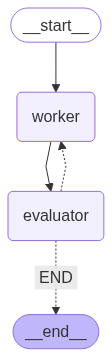

In [14]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
async def process_message(message: str, history: list, thread: str) -> tuple[list, str]:
    if not message:
        history.append({"role": "assistant", "content": "Please enter a flight query."})
        return history, thread
    
    try:
        async with asyncio.timeout(30):  # 30s timeout for LLM calls
            config = {"configurable": {"thread_id": thread}}
            input_state = {
                "messages": [HumanMessage(content=message)],
                "success_criteria": FIXED_SUCCESS_CRITERIA,
                "feedback_on_work": None,
                "success_criteria_met": False,
                "user_input_needed": False,
                "iteration_count": 0
            }
            result = await graph.ainvoke(input_state, config=config)
            user_msg = {"role": "user", "content": message}
            reply = {"role": "assistant", "content": result["messages"][-2].content}
            feedback = {"role": "assistant", "content": result["messages"][-1].content}
            return history + [user_msg, reply, feedback], thread
    except asyncio.TimeoutError:
        history.append({"role": "assistant", "content": "Processing timed out. Please try a simpler query or check your connection."})
        return history, thread
    except Exception as e:
        history.append({"role": "assistant", "content": f"Error: {str(e)}"})
        return history, thread

In [16]:
async def reset() -> tuple[str, list, str]:
    return "", [], str(uuid.uuid4())

In [17]:
with gr.Blocks(theme=gr.themes.Default(primary_hue="blue")) as demo:
    gr.Markdown("## Travel Chatbot")
    thread = gr.State(value=str(uuid.uuid4()))
    with gr.Row():
        chatbot = gr.Chatbot(label="Travel Assistant", height=400, type="messages")
    with gr.Group():
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="Enter your flight query (e.g., 'I want to fly from NYC to LA')")
    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")
    message.submit(process_message, [message, chatbot, thread], [chatbot, thread])
    go_button.click(process_message, [message, chatbot, thread], [chatbot, thread])
    reset_button.click(reset, [], [message, chatbot, thread])

In [18]:
if __name__ == "__main__":
    demo.launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.
